# Practical 4: Regression Mining

### In this practical
1. [Resuming from practical 3](#resume)
2. [Building your first logistic regression model](#build)
3. [Understanding your logistic regression model](#viz)
4. [Finding optimal hyperparameters with GridSearchCV](#gridsearch)
5. [Feature selection](#fselect)

---

**Written by Hendi Lie (h2.lie@qut.edu.au) and Richi Nayak (r.nayak@qut.edu.au). All rights reserved.**

This practical note introduces you to regression mining in Python. Regressions offer a different approach to predictive mining as compared to decision trees. As parametric models, they assume a specific association structure between inputs and target. This relationship can generally be represented by linear mathematical formula, which is used to classify/predict the target value. In contrast, decision trees do not assume any association structure; they simply seek to isolate concentrations of cases with like-valued targets.

In this practical, we will focus on logistic regression. Logistic regression is a class of regression model for classification task. It is similar in structure with linear regression, yet to make a classification prediction, transform the prediction value using logistic function. This practical will cover the key mathematical concepts of weights, logistic function and cost function of logistic regressions.

You will continue to use the **Veteran** dataset that you had prepared in practical 2.

## 1. Resuming from practical 3 <a name="resume"></a>

We will reuse code for data preprocessing from practical 2 and data partitioning from practical 3.

In [ ]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.model_selection import GridSearchCV 
from dm_tools import data_prep

# preprocessing step
df = data_prep()

# set the random seed - consistent
rs = 10

# train test split
y = df['TargetB']
X = df.drop(['TargetB'], axis=1)
X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

## 2. Building the logistic regression model<a name="build"></a>

### 2.1. Standardisation

Most machine learning/data mining algorithms, including regression models, are
sensitive to input variables on different scales. Input variables on different
scales makes comparison between data points difficult. (Recall the lecture
example of two variables with different scaled values: student grade (in the
range of 1-4) and student age (\~20-65)). In addition, it also adversely affects **gradient descent** (an algorithm used for training models such as regressions, neural networks, Support Vector Machines, etc) by making weights on larger scale inputs to update much faster than smaller scale inputs, resulting in suboptimal model performance.

> To read more about feature scaling, read this excellent blog post from Sebastian Raschka [link](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html)

To avoid this problem, it is necessary to perform standardisation on the input variables. Standardisation rescale input variables to have mean of 0 and standard deviation of 1, ensuring all of them are on the same scale. In `sklearn`, standardisation can easily be done using `StandardScaler`.

In [ ]:
from sklearn.preprocessing import StandardScaler

# initialise a standard scaler object
scaler = StandardScaler()

# visualise min, max, mean and standard dev of data before scaling
print("Before scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# learn the mean and std.dev of variables from training data
# then use the learned values to transform training data
X_train = scaler.fit_transform(X_train, y_train)

print("After scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# use the statistic that you learned from training to transform test data
# NEVER learn from test data, this is supposed to be a set of dataset
# that the model has never seen before
X_test = scaler.transform(X_test)

### 2.2. Training logistic regression

Once the input variables are scaled, we are ready to build the model. As
discussed before, the underlying problem is classification predictive mining,
therefore, a logistic regression model will be build for this classification
task. In sklearn, logistic regression is implemented in
`sklearn.linear_model.LogisticRegression`.

In [3]:
from sklearn.linear_model import LogisticRegression

Similar to decision tree, initiate a model object (with random state to ensure consistent result) and fit it to the training dataset. 

In [4]:
model = LogisticRegression(random_state=rs)

# fit it to training data
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=10, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

After the model is trained, evaluate the performance of the model on both training and test dataset.

In [5]:
# training and test accuracy
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# classification report on test data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.5935103244837758
Test accuracy: 0.5622849277357193
             precision    recall  f1-score   support

          0       0.56      0.57      0.57      1453
          1       0.56      0.55      0.56      1453

avg / total       0.56      0.56      0.56      2906



The model produces an acceptable accuracy score on the test data. The training accuracy is still slightly higher than the test accuracy, which indicates slight overfitting. We will tune this logistic regression model later using GridSearchCV.

## 3. Understanding your logistic regression model

Take a deeper look on the model we just built. Firstly, let's go over how logistic regression models makes predictions. 

Recall, the task is to predict whether a person with data (input variables) $x$ will be a lapsing donor. The target is $y$, which is a binary variable where 0 = non-lapsing donor and 1 = lapsing donor. Logistic regression will predict the target variable $y$ using function $g(\theta, x)$ as following:

$$h(\theta, x) = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \theta_{3}x_{3} + ... + \theta_{N}x_{N}$$

$$g(\theta, x) = \frac{1}{1 + e^{h(\theta, x)}}$$

$$y = target$$
$$x = input$$
$$\theta = weights$$

$h(\theta, x)$ is also commonly known as linear regression. The difference between logistic and linear regression is the function $g(\theta, x)$, also called **logistic/sigmoid** function. It transforms $h(\theta,x)$ into range of 0.0 to 1.0, which roughly translates to probability of $y = 1$ (positive, lapsing donor) given $x$. Sigmoid outputs smaller than 0.5 will be classified as 0 and the rest as 1. The output curve of $g(\theta, x)$ looks like this:

![logistic curve](http://dataminingtuts.s3.amazonaws.com/Logistic-curve.svg.png)

During the training process, the model tries to learn the optimal values of $\theta$ that results in the most accurate prediction. The algorithm used to find the optimal set of $\theta$ is called **optimisation algorithm**. Some examples of optimisation algorithm including gradient descent (most common and simple), LBFGS, adam, sag and newton-cg. These algorithms aim to minimise the **cost function**, which is the measure of how good predictions made by a model to the supplied $y_{train}$. Given weights of $\theta$, training set $X$ and $y$ with $m$ data points, the cost function $J(\theta)$ of a logistic regression is as follows:

$$J(\theta) = -\frac{1}{m}[\sum_{i=1}^{m} y^{(i)} \log h_{\theta}(x^{(i)}) + (1-y^{(i)}) \log (1-h_{\theta}(x^{(i)}))]$$

Once the model is trained, all of its weights are stored in `.coef_` array of the model.

In [ ]:
print(model.coef_)

Each of these values corresponds to a variable/feature in our dataset. We could print out feature name associated with each coefficient with this code below.

In [7]:
feature_names = X.columns
coef = model.coef_[0]

# limit to 20 features, you can comment the following line to print out everything
coef = coef[:20]

for i in range(len(coef)):
    print(feature_names[i], ':', coef[i])

GiftCnt36 : 0.08552948193516947
GiftCntAll : 0.057290576435774045
GiftCntCard36 : 0.09602623603523726
GiftCntCardAll : -0.07682680363608209
GiftAvgLast : -0.05033176383186588
GiftAvg36 : -0.039942998201834286
GiftAvgAll : 0.07375646123154629
GiftAvgCard36 : -0.05930713749119237
GiftTimeLast : -0.16833272253237708
GiftTimeFirst : 0.2804476485075328
PromCnt12 : -0.13986483628630772
PromCnt36 : 0.050613998282111314
PromCntAll : 0.19782012741923985
PromCntCard12 : 0.04778419148279742
PromCntCard36 : 0.09494982421661088
PromCntCardAll : -0.43851255905848474
StatusCatStarAll : 0.11004787142872036
DemAge : 0.0551011404105965
DemHomeOwner : 0.027000444465008322
DemMedHomeValue : 0.12585620936003922


Recall again that a linear/logistic regression model assumes linear correlation between input features and prediction values. This relationship is reflected in the weight values.
* Positive coefficient means positive change in the input feature has positive correlation to the prediction value. **DemAge** has positive coefficients, which means older donors (larger age value) are predicted to be more likely to donate back.

* Negative coefficient does the reverse. For example, **GiftTimeLast** has negative coefficient, thus if a donor has not donated for a while, the model predicts it is less likely for them to be a lapsing donor.

In addition to understanding positive/negative correlations between features and prediction values, it is important to learn how much a feature impact the overall prediction value (i.e. feature importance). One way to answer this question is by looking at the absolute value of coefficients. Changes in an important variable (either positive or negative) should correlate to a larger impact to prediction value, thus the coefficient assigned to this variable will have a large absolute value. 

This method only applies when the features are standard scaled. Without scaling, each feature can be on different range of values, making larger ranged feature more important by default. For example, in a dataset with **age** and **income**, a **+10** increase in age is significant, but it is meaningless in income. In this scenario, without scaling the coefficients do not help in finding important variables.

The following code will sort the coefficients by their largest absolute value and print the corresponding feature names.

In [8]:
# grab feature importances from the model and feature name from the original X
coef = model.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 20 features, you can leave this out to print out everything
indices = indices[:20]

for i in indices:
    print(feature_names[i], ':', coef[i])

PromCntCardAll : -0.43851255905848474
GiftTimeFirst : 0.2804476485075328
PromCntAll : 0.19782012741923985
GiftTimeLast : -0.16833272253237708
PromCnt12 : -0.13986483628630772
DemMedHomeValue : 0.12585620936003922
StatusCatStarAll : 0.11004787142872036
GiftCntCard36 : 0.09602623603523726
PromCntCard36 : 0.09494982421661088
GiftCnt36 : 0.08552948193516947
StatusCat96NK_E : 0.07764783220730546
GiftCntCardAll : -0.07682680363608209
GiftAvgAll : 0.07375646123154629
GiftAvgCard36 : -0.05930713749119237
GiftCntAll : 0.057290576435774045
DemAge : 0.0551011404105965
DemCluster_47 : -0.052835847813307045
DemCluster_10 : -0.051878252493531646
DemCluster_30 : -0.051188895697830736
PromCnt36 : 0.050613998282111314


Based on this output, the most important variables in this model is PromCntCardAll, GiftTimeFirst, and PromCntAll. These important variables will be different from one model to another.

## 4. Finding optimal hyperparameters with GridSearchCV

Similar to the previous practical, this section will guide you to tune the default model to perform better. In this example, we will only tune one hyperparameter from our logistic regression model, the regularisation strength used in the model. Regularisation is a technique used to prevent overfitting in regression models. We will not go in depth to explain how regularisation works, you can find more information here:
* [Basic of regularisation](https://www.quora.com/What-is-regularization-in-machine-learning)
* [L1 vs L2 regularisation](http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/)

In `sklearn` logistic regression, regularisation is implemented in the hyperparameter **C**, which denotes the inverse of regularisation strength. Smaller C means stronger regularisation. Typical values for C range from $10^{-6}$ to $10^{4}$, increasing in logarithmic order, which are the values we will use in this example.

**Tips:** `GridSearchCV` can be slow for searching over a large set of possible values. To speed up the searching process, `GridSearchCV` has parallel running capability, where you can specify how many parallel processes running in the same time with `n_jobs` (-1 means GridSearchCV will use as many cores as possible).

In [ ]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

# test the best model
print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

y_pred = cv.predict(X_test)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

GridSearchCV returns `C` = 0.001 as the optimal parameter. The model has a slight (almost negligble) improvement on the test data. In the next section, we will explore model improvement techniques beyond GridSearch.

## 5. Input transfomation and dimensionality reduction

Other than fine tuning models by performing grid search over their hyperparameters, there are many methods to improve prediction quality from a model. One way is to improve the input features itself, such as with input transformation. In this technique, methods that changes input distribution such as log transformation or exponential function are applied.

Another method to improve prediction quality from a model is to perform dimensionality reduction or feature selection on the input set. The aim of dimensionality reduction is to reduce the size of input set hoping that it will improve model performance, reduce overfitting and enhance visualiation. Dimensionality reduction is divided into two processes:
* Feature selection: Process of selecting a subset of relevant features/variables to be used in constructing models.
* Feature extraction: Process of transforming high-dimensional feature space into lower dimension. Typically performed by finding principle components of the feature space.

In the following sections, we will explore some input transformation and dimensionality reduction techniques.

### 5.1. Logarithmic transformation

Regression models are sensitive to extreme or outlying values in the input space. Inputs with highly skewed or kurtotic distributions are often selected over inputs with better overall predictions. To avoid this problem, analysts often regularise the input distributions using a simple transformation. This approach could improves model performance, at cost of increased difficulty in interpretation.

Examine the variables with **GiftAvg** and **GiftCnt** in their names. Plot their distributions using `sns.distplot`.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_skewed_columns(df):
    # setting up subplots for easier visualisation
    f, axes = plt.subplots(2,4, figsize=(10,10), sharex=False)

    # gift avg plots
    sns.distplot(df['GiftAvg36'].dropna(), hist=False, ax=axes[0,0])
    sns.distplot(df['GiftAvgAll'].dropna(), hist=False, ax=axes[0,1])
    sns.distplot(df['GiftAvgCard36'].dropna(), hist=False, ax=axes[1,0])
    sns.distplot(df['GiftAvgLast'].dropna(), hist=False, ax=axes[1,1])

    # gift cnt plots
    sns.distplot(df['GiftCnt36'].dropna(), hist=False, ax=axes[0,2])
    sns.distplot(df['GiftCntAll'].dropna(), hist=False, ax=axes[0,3])
    sns.distplot(df['GiftCntCard36'].dropna(), hist=False, ax=axes[1,2])
    sns.distplot(df['GiftCntCardAll'].dropna(), hist=False, ax=axes[1,3])

    plt.show()
    
plot_skewed_columns(df)

The **GiftAvg** and **GiftCnt** columns show some degree of skew in their distribution. To normalise this skewed distributions, use the log transformation. Log transformation measure the order of magnitude of the underlying measure instead of the measure itself.

Use `pandas.apply()` to apply `np.log()` transformation over these columns.

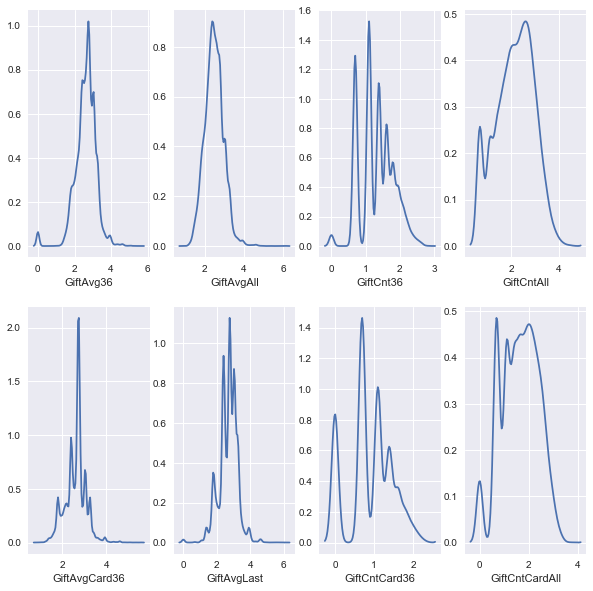

In [11]:
import numpy as np

# list columns to be transformed
columns_to_transform = ['GiftAvg36', 'GiftAvgAll', 'GiftAvgCard36', 'GiftAvgLast',
                        'GiftCnt36', 'GiftCntAll', 'GiftCntCard36', 'GiftCntCardAll']

# copy the dataframe
df_log = df.copy()

# transform the columns with np.log
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)

# plot them again to show the distribution
plot_skewed_columns(df_log)

After transformation, the columns are much more normally distributed. The next step is to test whether this transformation benefits performance of the model.

Start by rescaling and resampling the training and test data.

In [12]:
# create X, y and train test data partitions
y_log = df_log['TargetB']
X_log = df_log.drop(['TargetB'], axis=1)
X_mat_log = X_log.as_matrix()
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y_log, test_size=0.3, stratify=y_log, 
                                                                    random_state=rs)

# standardise them again
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log, y_train_log)
X_test_log = scaler_log.transform(X_test_log)

After the training and test data is ready, run a grid search to find the optimal **C** value again.

In [13]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

# test the best model
print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))

y_pred = cv.predict(X_test_log)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.59395280236
Test accuracy: 0.566758430833
             precision    recall  f1-score   support

          0       0.56      0.58      0.57      1453
          1       0.57      0.55      0.56      1453

avg / total       0.57      0.57      0.57      2906

{'C': 0.001}


Similar to the previous model with optimal **C** value (0.001), log transformation only managed to increased the model performance slightly on the test performance.

### 5.2. Recursive feature elimination

The next method is a dimensionality reduction technique called recursive feature elimination (RFE). RFE works by first training the model on all features. Each feature then will be assigned an weight, and features with smallest weight (less important) is eliminated, making a smaller feature set. This process is repeated a number of times until reaching the optimal performance.

In this practical, we will use RFE with cross validation. Cross validation allows RFE to generalise better over the training dataset. RFE with CV is implemented in sklearn under `sklearn.feature_selection.RFECV`. Initiate the RFE with a logistic regression estimator and 10-fold validation and fit it to start eliminating features.

In [14]:
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 85
Number of features after elimination 40


The RFE+CV process output 40 features as the optimal number of features. This means that according to the model, there are only 40 variables in the input set that are important to the analysis. We can now `.transform()` the original input set, taking only the important features.

In [15]:
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

Run another `GridSearchCV` and test if the new input set improves the model performance.

In [16]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel, y_train)

# test the best model
print("Train accuracy:", cv.score(X_train_sel, y_train))
print("Test accuracy:", cv.score(X_test_sel, y_test))

y_pred = cv.predict(X_test_sel)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.593510324484
Test accuracy: 0.56882312457
             precision    recall  f1-score   support

          0       0.57      0.58      0.57      1453
          1       0.57      0.56      0.56      1453

avg / total       0.57      0.57      0.57      2906

{'C': 100}


The RFE also managed to only slightly improve the accuracy of our model on test data. More importantly, with much smaller feature set, the training, testing and prediction process is speed up significantly.

RFE could also be combined with other dimensionality reduction and transformation techniques. For example, we could combine it with log transformation by running RFE on the log transformed input set. Use the following code and see the combined approach improves the model performance.

In [21]:
# running RFE + log transformation
rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train_log, y_train_log) # run the RFECV on log transformed dataset

# comparing how many variables before and after
print("Original feature set", X_train_log.shape[1])
print("Number of features after elimination", rfe.n_features_)

# select features from log transformed dataset
X_train_sel_log = rfe.transform(X_train_log)
X_test_sel_log = rfe.transform(X_test_log)

# init grid search CV on transformed dataset
params = {'C': [pow(10, x) for x in range(-6, 4)]}
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel_log, y_train_log)

# test the best model
print("Train accuracy:", cv.score(X_train_sel_log, y_train_log))
print("Test accuracy:", cv.score(X_test_sel_log, y_test_log))

y_pred_log = cv.predict(X_test_sel_log)
print(classification_report(y_test_log, y_pred_log))

# print parameters of the best model
print(cv.best_params_)

Original feature set 85
Number of features after elimination 34
Train accuracy: 0.592330383481
Test accuracy: 0.570543702684
             precision    recall  f1-score   support

          0       0.57      0.58      0.57      1453
          1       0.57      0.57      0.57      1453

avg / total       0.57      0.57      0.57      2906

{'C': 0.01}


RFE also managed to improve performance of the model on the log transformed dataset.

### 5.3. Feature selection using another model

The last method we will explore in this practical is "select from model". In this technique, we utilise machine learning models with ability to find feature importance and select the feature set using the computed importance from the trained model. Typically, decision tree or support vector machine models are used in this method. Recall from the previous practical that decision trees can compute feature importance internally through the tree structure. Therefore, we will use decision tree as "selecting model" here.

We will utilise the log transformed dataset for this purpose. Initialise a GridSearchCV with DecisionTreeClassifier and fit it to the training data.

In [32]:
from sklearn.tree import DecisionTreeClassifier

# similar parameters with the last practical
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 7),
          'min_samples_leaf': range(20, 60, 10)}

cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(X_train_log, y_train_log)

print(cv.best_params_)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 50}


Once the decision tree is trained, analyse the feature importance from this trained model using `analyse_feature_importance()` function we wrote in the previous practical.

In [ ]:
from dm_tools import analyse_feature_importance

# analyse feature importance from the tuned decision tree against log transformed X
analyse_feature_importance(cv.best_estimator_, X_log.columns)

The output shows there are only 16 features with importance value more than 0. This means according to the tuned decision tree, there are only 16 important features in our dataset. We could now use this decision tree to perform feature selection.

Import `SelectFromModel` module from `sklearn.feature_selection`.

In [36]:
from sklearn.feature_selection import SelectFromModel

# use the trained best decision tree from GridSearchCV to select features
# supply the prefit=True parameter to stop SelectFromModel to re-train the model
selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train_log)
X_test_sel_model = selectmodel.transform(X_test_log)

print(X_train_sel_model.shape)

(6780, 14)


The shape of X_train shows there are only 14 feature left, exactly what the decision tree suggests. Next, train and tune another logistic regression model from this new data set and see if it improves the performance.

In [37]:
params = {'C': [pow(10, x) for x in range(-6, 4)]}

cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_sel_model, y_train_log)

print("Train accuracy:", cv.score(X_train_sel_model, y_train_log))
print("Test accuracy:", cv.score(X_test_sel_model, y_test_log))

# test the best model
y_pred = cv.predict(X_test_sel_model)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

Train accuracy: 0.581710914454
Test accuracy: 0.570543702684
             precision    recall  f1-score   support

          0       0.57      0.58      0.58      1453
          1       0.57      0.56      0.57      1453

avg / total       0.57      0.57      0.57      2906

{'C': 0.01}


The test accuracy result shows improvement over the original feature set as well. In addition, the feature set now only has 14 features compared to the original 85, translating to huge computation power saved. This demonstrates the effectiveness of dimensionality reduction.

## End notes

This lecture note taught us how to build, tune and explore the structure of
logistic regression models. We also explored transformation and dimensionality
reduction techniques to overcome skewed distribution and reduce the size of the feature set and improve performance of our logistic regression model.